# eda_books_이은지.ipynb
- category를 위주로 컬럼 간의 관계 파악
- 초기에 진행했던 eda
- 지금 생각해보니 book_author 전처리도 제대로 안한듯 ..

## 0. 데이터 불러오기

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
base_path = os.path.join(os.curdir, 'data')
book_path = os.path.join(base_path, 'books.csv')
books = pd.read_csv(book_path, encoding='utf-8')

In [4]:
# book shape 확인
books.shape

(149570, 10)

In [5]:
print('isbn 개수: ', books['isbn'].nunique())               # isbn은 다 다름
print('book_title 개수: ', books['book_title'].nunique())   # 동일한 책 제목 있음

isbn 개수:  149570
book_title 개수:  135436


In [6]:
# 초기 nan 확인
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

In [7]:
books.nunique()

isbn                   149570
book_title             135436
book_author             62059
year_of_publication        95
publisher               11571
img_url                149570
language                   26
category                 4292
summary                 79872
img_path               149570
dtype: int64

## 1. publisher 재그룹화

In [6]:
# publisher 당 데이터 수 count 
publisher_dict = (books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()), columns=['publisher', 'count'])
publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending=False)

In [7]:
# top5 publisher 확인
publisher_count_df.head()

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


In [8]:
# 전처리 전 publisher 수 
books['publisher'].nunique()

11571

In [9]:
# isbn 앞 4자리를 통해 publisher 추정 
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [10]:
# 전처리 후 publisher 수
books['publisher'].nunique()

1523

In [11]:
# 책이 한 권인 출판사도 있음
books['publisher'].value_counts()

Pocket                        7306
Harlequin                     5268
Bantam Books                  4815
St. Martin's Press            4043
Vintage Books USA             3822
                              ... 
Oh Editions                      1
Saur                             1
Rossmen                          1
Tascabili Economici Newton       1
Information                      1
Name: publisher, Length: 1523, dtype: int64

## 2. category

### 2-0. 기본 데이터 처리 (str, 소문자 변환)

In [28]:
# category가 있는 경우의 category 확인 (여러개 있나)
books[books['category'].notnull()]['category'].head()

0    ['Actresses']
1    ['1940-1949']
2      ['Medical']
3      ['Fiction']
4      ['History']
Name: category, dtype: object

In [29]:
# str으로 바꾸기
import re
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

In [30]:
# 소문자로 바꾼 후 category 당 count 확인
books['category'] = books['category'].str.lower()
books['category'].value_counts() 

fiction                                            33016
juvenile fiction                                    5835
biography autobiography                             3326
history                                             1927
religion                                            1818
                                                   ...  
brenner simon fictitious character                     1
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
authors canadian english 20th century biography        1
Name: category, Length: 4105, dtype: int64

In [31]:
# category 종류 - count dataframe 만들기
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
# top10 category 확인
category_df.head(10)

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818
5,juvenile nonfiction,1418
6,social science,1231
7,humor,1161
8,body mind spirit,1113
9,business economics,1073


In [32]:
more_50 = category_df[category_df['count'] > 50]
more_50.tail(30)

,category,count
45,adventure stories,132
46,games activities,128
47,games,125
48,architecture,116
49,american fiction,116
50,law,104
51,antiques collectibles,97
52,english fiction,93
53,friendship,84
54,brothers and sisters,84


In [18]:
# category 확인용 
category_df[category_df['category'].str.contains('histori')
# & category_df['category'].str.contains('religion') 
# & ~(category_df['category'].str.contains(' s'))
].head(20)

,category,count
156,historical fiction,17
609,antiquities prehistoric,4
879,chronology historical,3
1221,historians,2
1440,historic sites,2
1517,historiography,2
1550,imaginary histories,2
1872,alternative histories fiction,1
1875,art historians,1
1924,alternative histories,1


### 2-1. 각 column 간의 관계 시각화

- 시각화 해보니 최빈값으로 하는 것 괜찮아 보임
- 근데 너무 데이터가 많아서 일부만 추출해서 본 것임

In [98]:
# count dataframe
book_author_df = pd.DataFrame(books['book_author'].value_counts()).reset_index()
book_author_df.columns = ['book_author', 'count']

book_title_df = pd.DataFrame(books['book_title'].value_counts()).reset_index()
book_title_df.columns = ['book_title', 'count']

book_publisher_df = pd.DataFrame(books['publisher'].value_counts()).reset_index()
book_publisher_df.columns = ['publisher', 'count']


In [133]:
# heatmap을 위한 범위 설정 
category_list = category_df[(category_df['count'] > 500) & (category_df['count'] > 500)]['category'].tolist()
author_list = book_author_df[(book_author_df['count'] > 100)]['book_author'].tolist()
title_list = book_title_df[(book_title_df['count'] > 8)]['book_title'].tolist()
publisher_list = book_publisher_df[(book_publisher_df['count'] > 400)]['publisher'].tolist()

In [134]:
df = books[['book_author', 'category']].dropna()
df = df.groupby(['book_author', 'category']).size().unstack().fillna(0)
df

category,0,0islands,101 dalmatians motion picture,11030 fiction in english 1900 1945 60030 texts,11030 short stories in english p1030 canadian writers 1945 60030 texts,1800 1899,1900 1999,1940 1949,20th century general fiction,35mm cameras,...,yoga,yorkshire england,young adult fiction,young adult nonfiction,young adults,young men,zanzibar,zen buddhism,zeugen jehovas weibliche jugend ausstieg jugendbuch,zip code
book_author,,,,,,,,,,,,,,,,,,,,,
D. Chiel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A A Milne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Blue Mountain Arts Collection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bodenburg Sommer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A E Hartink,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stephen R Donaldson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
translated by Rumer Godden,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='category', ylabel='book_author'>

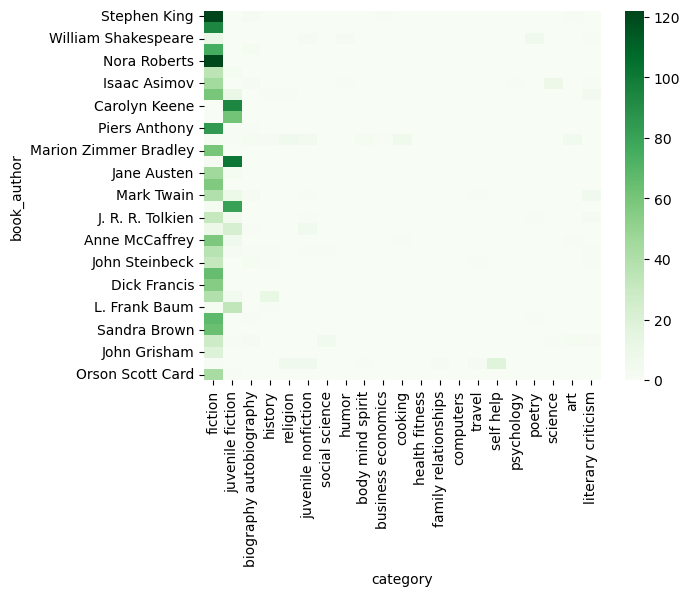

In [135]:
sns.heatmap(df.loc[author_list, category_list], cmap='Greens')

In [136]:
df = books[['book_title', 'category']].dropna()
df = df.groupby(['book_title', 'category']).size().unstack().fillna(0)
df

category,0,0islands,101 dalmatians motion picture,11030 fiction in english 1900 1945 60030 texts,11030 short stories in english p1030 canadian writers 1945 60030 texts,1800 1899,1900 1999,1940 1949,20th century general fiction,35mm cameras,...,yoga,yorkshire england,young adult fiction,young adult nonfiction,young adults,young men,zanzibar,zen buddhism,zeugen jehovas weibliche jugend ausstieg jugendbuch,zip code
book_title,,,,,,,,,,,,,,,,,,,,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Ask Lily (Young Women of Faith: Lily Series, Book 5)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dark Justice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Final Fantasy Anthology: Official Strategy Guide (Brady Games),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Flight of Fancy: American Heiresses (Zebra Ballad Romance),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Â¿QuÃ© me quieres, amor?",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ã?ngeles fugaces (Falling Angels),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ã?Â?ber das Fernsehen.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='category', ylabel='book_title'>

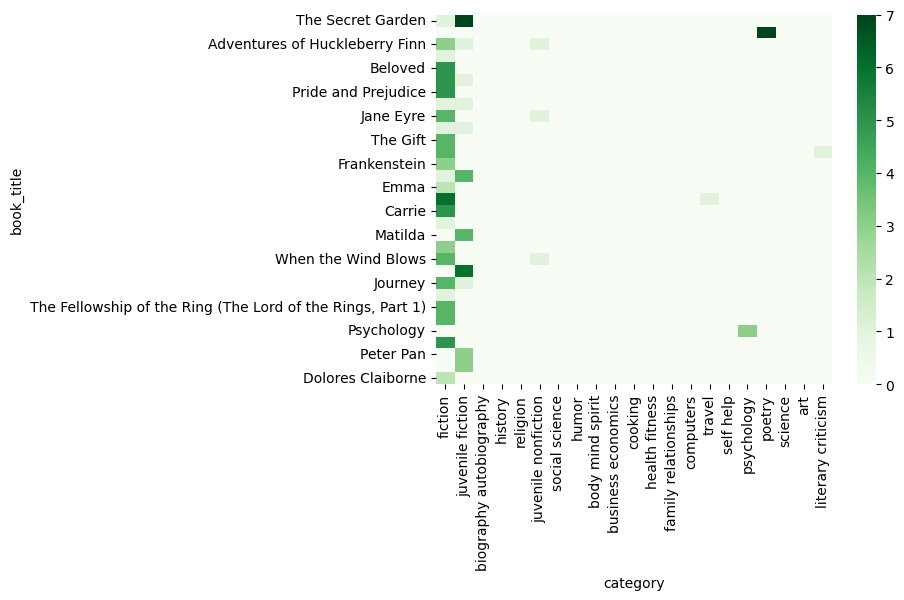

In [137]:
sns.heatmap(df.loc[title_list, category_list], cmap='Greens')

In [138]:
df = books[['publisher', 'category']].dropna()
df = df.groupby(['publisher', 'category']).size().unstack().fillna(0)
df

category,0,0islands,101 dalmatians motion picture,11030 fiction in english 1900 1945 60030 texts,11030 short stories in english p1030 canadian writers 1945 60030 texts,1800 1899,1900 1999,1940 1949,20th century general fiction,35mm cameras,...,yoga,yorkshire england,young adult fiction,young adult nonfiction,young adults,young men,zanzibar,zen buddhism,zeugen jehovas weibliche jugend ausstieg jugendbuch,zip code
publisher,,,,,,,,,,,,,,,,,,,,,
1stBooks Library,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A. Kunstmann,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A. Mondadori,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A. S. Barnes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AK Press,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zebra Books,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zondervan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zondervan Publishing Company,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='category', ylabel='publisher'>

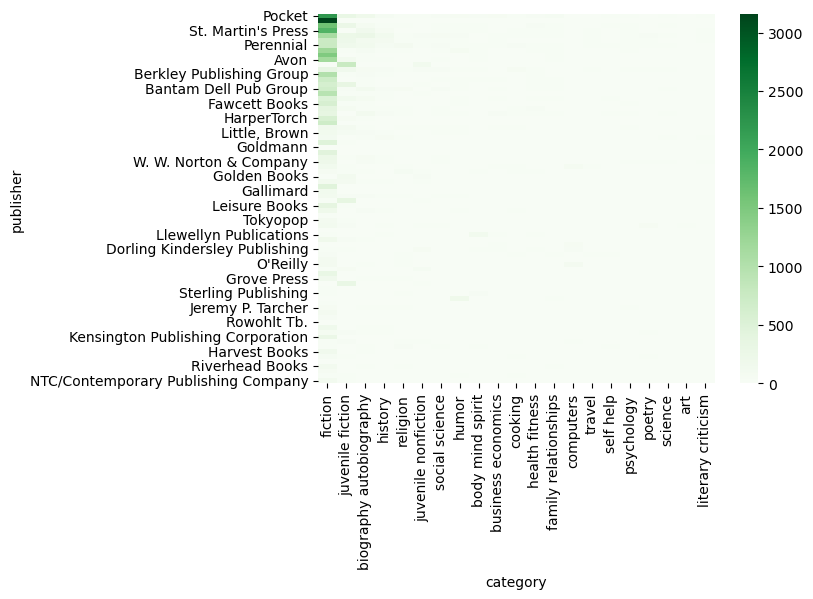

In [139]:
sns.heatmap(df.loc[publisher_list, category_list], cmap='Greens')

### 2-2. category 재그룹화

#### fiction은 자세하게 / nonfiction은 묶어서 분류해보기 
- 시도해보고 싶긴 한데 방법이 없어서 보류중

#### `category_high` : 미션 주어진 대분류 그대로 재그룹화
- 미션 제공 코드

In [19]:
# 현재 카테고리를 categories로 변경 
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

# 현재 카테고리에 categories에 포함되는 단어가 있으면 해당 category
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [20]:
len(categories)

43

In [21]:
# high category - count dataframe 만들기 
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df[category_high_df['count'] > 100]

,category,count
0,fiction,39678
1,religion,1824
2,nonfiction,1427
3,humor,1291
4,social,1271
5,business,1146
6,cook,1125
7,science,1063
8,family,988
9,literary,848


In [22]:
# 5개 이하인 항목은 others로 묶어주기
others_list = category_high_df[category_high_df['count']<5]['category'].values

In [23]:
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

In [24]:
print('원래 category 개수:', books['category'].nunique())
print('바뀐 category_high 개수:', books['category_high'].nunique())

원래 category 개수: 4105
바뀐 category_high 개수: 43


In [25]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          90691
dtype: int64

In [26]:
test_df = pd.DataFrame(books[books['category'].str.contains('computer', na=False)][['category', 'category_high']].value_counts()).reset_index()
test_df.columns = ['category', 'category_high', 'count']
test_df.head(10)

,category,category_high,count
0,computers,computer,730
1,computer networks,computer,13
2,java computer program language,language,7
3,computer graphics,computer,6
4,macintosh computer,computer,5
5,microcomputers,computer,5
6,microsoft windows computer file,computer,4
7,c computer program language,language,4
8,computer science,computer,3
9,computer software,computer,3


#### `category_high_v2`: 카테고리 재그룹화 (ChatGPT 사용)
- 기정님 코드

In [27]:
dict_ = {
    "fiction2": ["detective and mystery stories american","detective and mystery stories english", "mothers and daughters", "abduction", "abused wives", "drama", "dwellings", "good and evil", "middle earth imaginary place", "frontier and pioneer life", "mothers and sons", "authors american", "castaways", "adventure", "detective and mystery stories", "true crime", "dune imaginary place", "humor", "child development", "comics graphic novels", "horror tales", "crime", "arranged marriage", "bildungsromans", "baggins bilbo fictitious character", "love stories", "divorce", "science fiction", "murder", "ghost stories", "interplanetary voyages", "brunetti guido fictitious character", "arthurian romances", "fairy tales", "success", "discworld imaginary place", "beauty personal", "horror", "fantasy", "ghosts", "women", "married people", "feminism", "earthquakes", "classic", "dent arthur fictitious character", "betrothal", "blake anita fictitious character", "novel", "horror stories", "courtship", "detective and mystery stories"], 
    "fiction1" : ["fiction"],
    "nonfiction" : ["nonfiction"],
    "biograph_autobiograph": ["biography", "biography autobiography"], 
    "history_culture": ["aboriginal australians","archaeology" ,"erotic stories american","russia", "unidentified flying objects", "antarctica", "brazil", "paris france", "united states", "chicago ill", "great britain", "astrology", "british", "city planning", "israel", "new york n y", "london england", "holocaust jewish 1939 1945", "jews", "cornwall england county", "china", "arkansas", "baltimore md", "greece", "civilization medieval", "soviet union", "africa north", "boston mass", "aeronautics", "california", "arizona", "current events", "africa", "advertising", "americans", "france", "florida", "germany", "europe", "egypt", "world war 1939 1945", "antisemitism", "alaska", "arab israeli conflict", "vietnam war 1961 1975", "scotland", "canada", "celts", "bible", "amsterdam netherlands", "devotional calendars", "castles", "minnesota", "colombia", "berlin germany", "chile", "dracula count fictitious character", "african americans", "african american families", "history", "mexico", "india", "japan", "italy", "england", "arctic regions", "brooklyn new york n y", "australia", "ireland", "spain", "christmas stories", "caribbean area", "athens greece", "cathedrals", "antiquities", "trojan war", "journalism", "history modern", "civilization", "cities and towns"], 
    "religion_philosophy": ["clergy", "religion", "mythology", "christian", "bible", "buddhism", "god", "meditation", "consciousness", "covenant thomas fictitious character", "apologetics", "bible stories", "fables", "catholics", "philosophy", "angels", "self help", "alchemists", "ethics", "extrasensory perception", "christmas", "bibles", "bible stories english"], 
    "science_nature": ["mathemat", "robots", "architect", "herbs", "idaho", "biology", "hiking", "health", "chemistry", "motion picture", "infants", "aliens", "brain", "current events", "dinosaurs", "technology engineering", "ecology", "nature", "monsters", "environmental", "natural history", "science", "counting", "atomic bomb", "cats", "cosmology", "elephants", "bird", "physics", "astronomy", "life on other planets", "veterinarians", "animal", "mice", "extraterrestrial beings", "color", "ducks", "disease"],
    "human psychology_self-development": ["photograph", "bullies", "books and reading", "psycholog", "courage", "girls", "conduct of life", "children", "achievement motivation", "depressions", "fear", "body mind spirit", "emotions", "mental illness", "dreams", "dream interpretation", "anger", "spiritual life", "adolescence", "behavior", "behavior modification", "intelligence service", "man woman relationships", "contests", "gay men", "amnesia", "consumer education", "abortion", "executive ability", "study aids", "curiosities and wonders", "bashfulness", "adultery", "love"], 
    "cook_food": ["chocolate", "diet", "food", "cook", "chickens"], 
    "health": ["exercise", "health", "cancer", "medical", "health fitness", "medicine popular"], 
    "home_life": ["brothers", "homeless persons", "communication in marriage", "child care", "home economics", "diaries", "house", "aromatherapy", "pets", "birthdays", "childbirth", "clubs", "manners and customs", "aging", "clothing and dress", "country life", "family", "relaxation", "child rearing", "interior decoration", "christmas decorations", "garden", "country homes", "death", "bereavement", "dolls", "father and child", "farm life", "handicraft"], 
    "art_literature": ["almanacs", "crafts" ,"baggins frodo fictitious character" ,"authors austrian", "actresses", "african american authors", "authors spanish", "authors french", "authors", "poetry", "african american women", "journalists", "authors english", "comedians", "design", "reference", "music", "plot your own stories", "african american men", "authors german", "acting", "authors australian", "artists", "biographers", "encyclopedias and dictionaries", "quotations english", "literary", "literature", "performing arts", "ballet", "criticism", "short stories", "comic books strips etc", "art", "drawing", "horror tales american", "stories in rhyme", "antiques collectibles"], 
    "society_human relations": ["homicide", "adoptees", "college teachers", "people with mental disabilities", "celebrities", "female friendship", "aunts", "kings and rulers", "college readers", "law", "boarding schools", "grandmothers", "beaches", "inheritance and succession", "presidents", "sociology", "anger", "friendship", "alphabet", "man woman relationships", "high schools", "interpersonal relations", "antiques", "humor", "cousins", "education", "brothers and sisters", "blind", "child abuse", "arranged marriage", "mystery and detective stories", "fathers and daughters", "college students", "alcoholics", "fathers and sons", "families", "conspiracies", "babysitters", "police", "devil", "entertainers", "singers", "high school students", "avarice", "communication", "government investigators", "success", "social", "accidents", "questions and answers", "benefactors", "readers", "actors", "generals", "sisters"], 
    "economy_business": ["finance personal", "nuclear warfare", "hollywood los angeles calif", "business", "coal miners", "economics", "capitalism", "drug abuse", "applications for positions", "antique dealers"], 
    "computer_internat": ["transportation", "sat educational test", "internet", "chess", "androids", "artificial intelligence", "electronic", "computer"], 
    "game_leisure": ["camp", "buried treasure" ,"baseball", "cowboys", "cruise ships", "soccer", "halloween", "amusements", "circus", "fantasy games", "travel", "asterix fictitious character", "tarot", "horse racing", "fairies", "magic", "clowns", "sports recreation", "games", "cheerleading", "caricatures and cartoons", "games activities", "bicycle touring"], 
    "other": ["colorado","assassins", "air pilots", "dragons", "boys", "city and town life", "cults", "vampires", "audiocassettes", "outer space", "autumn",  "accelerated readers", "consciousness", "schools", "lesbians", "book burning", "language", "baseball stories", "board books", "others", "large type books", "audiobooks", "executives", "folklore", "criminal", "beats persons", "missing persons", "orphans", "names personal", "elves", "adoption", "composers", "eskimos", "human alien encounters", "feng shui", "canon literarature", "ex convicts", "alternative medicine", "kidnapping", "bedtime", "authorship"], 
    "animals": ["dogs", "frogs", "bears", "rabbits", "horses", "ants"]
}

In [28]:
books["category_high_v2"] = books['category_high'].copy()

for key in dict_.keys():
    set_ = set(dict_[key])
    books.loc[books[books['category_high'].isin(set_)].index , 'category_high_v2'] = key

books['category_high_v2'].value_counts()

fiction1                             39678
society_human relations               2575
art_literature                        2540
religion_philosophy                   2453
science_nature                        1663
home_life                             1485
human psychology_self-development     1429
nonfiction                            1427
economy_business                      1146
cook_food                             1125
fiction2                               873
other                                  846
computer_internat                      831
game_leisure                           710
history_culture                         98
Name: category_high_v2, dtype: int64

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 2-3. category 결측치 imputation

#### Author 별 최빈값으로 imputation
- 작성자: 이은지

In [33]:
# book author - count DataFrame
book_author_df = pd.DataFrame(books['book_author'].value_counts()).reset_index()
book_author_df.columns = ['book_author', 'count']

In [30]:
same_author_book = book_author_df[book_author_df['count']>1]['book_author'].values.tolist()

In [32]:
for author in same_author_book:
    same_author = (books['book_author'] == author)
    if books.loc[same_author, 'category_high_v2'].isnull().all():
        continue
    else:
        category_mode = books.loc[same_author, 'category_high_v2'].mode()[0]
        books.loc[same_author, 'category_high_v2'] = books.loc[same_author, 'category_high_v2'].fillna(category_mode)

In [33]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          90691
category_high_v2       44911
dtype: int64

#### Title 별 최빈값으로 Imputation
- 작성자: 이은지

In [34]:
# book title - count DataFrame
book_title_df = pd.DataFrame(books['book_title'].value_counts()).reset_index()
book_title_df.columns = ['book_title', 'count']

In [35]:
same_title_book = book_title_df[book_title_df['count']>1]['book_title'].values.tolist()

In [36]:
for title in same_title_book:
    same_title = books['book_title'] == title
    if books.loc[same_title, 'category_high_v2'].isnull().all():
        continue
    else:
        category_mode = books.loc[same_title, 'category_high_v2'].mode()[0]
        books.loc[same_title, 'category_high_v2'] = books.loc[same_title, 'category_high_v2'].fillna(category_mode)

In [37]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          90691
category_high_v2       43688
dtype: int64

#### Publisher 별 최빈값으로 imputation
- 작성자: 이은지

In [38]:
# book publisher - count DataFrame
book_publisher_df = pd.DataFrame(books['publisher'].value_counts()).reset_index()
book_publisher_df.columns = ['publisher', 'count']

In [39]:
same_publisher_book = book_publisher_df[book_publisher_df['count']>1]['publisher'].values.tolist()

In [40]:
for publisher in same_publisher_book:
    same_publisher = (books['publisher'] == publisher)
    if books.loc[same_publisher, 'category_high_v2'].isnull().all(): # 최빈값 여러개일 때 어떻게 처리할지 
        continue
    else:
        category_mode = books.loc[same_publisher, 'category_high_v2'].mode()[0]
        books.loc[same_publisher, 'category_high_v2'] = books.loc[same_publisher, 'category_high_v2'].fillna(category_mode)

In [41]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          90691
category_high_v2         994
dtype: int64

In [42]:
books['category_high_v2'].value_counts() 

fiction1                             111870
art_literature                         5776
religion_philosophy                    4679
society_human relations                4104
science_nature                         2898
nonfiction                             2730
home_life                              2694
human psychology_self-development      2467
cook_food                              2366
economy_business                       2171
fiction2                               1805
computer_internat                      1752
game_leisure                           1603
other                                  1524
history_culture                         137
Name: category_high_v2, dtype: int64

## 3. language

### 3-1. isbn 첫 숫자로 language imputation

- 증원님 코드

In [43]:
# 임시로 data -> books 로 변경
#               vvvvvvvv 여기
isbn_startwith = books['isbn'].apply(lambda x: x[0]).value_counts().index[:]

most_language_for_isbn = {}
for isbn_s in isbn_startwith:
    if len(list(books[books['isbn'].str.startswith(isbn_s)]['language'].value_counts().to_dict().items())) != 0:
        most_language_for_isbn[isbn_s] = list(books[books['isbn'].str.startswith(isbn_s)]['language'].value_counts().to_dict().items())[0][0]
    else:
        # 하나도 없는거는 isbn이 B로 시작하는 경우인데 그 경우 책이 영어로 되어있다.
        most_language_for_isbn[isbn_s] = 'en'
print(most_language_for_isbn)

{'0': 'en', '1': 'en', '3': 'de', '8': 'es', '2': 'fr', '9': 'es', '4': 'en', 'B': 'en', '5': 'en', '7': 'zh-CN'}


In [44]:
# 임시로 data -> books 로 변경
#               vvvvvvvv 여기
isbn_startwith = books['isbn'].apply(lambda x: x[0]).value_counts().index[:]

for isbn_s in isbn_startwith:
    books.loc[(books['isbn'].str.startswith(isbn_s) & books['language'].isna()), 'language'] = most_language_for_isbn[isbn_s]

In [45]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language                   0
category               68851
summary                67227
img_path                   0
category_high          90691
category_high_v2         994
dtype: int64

## 4. csv 파일로 저장하기 

In [46]:
# column 이름 바꾸기 
books = books.rename(columns={'category': 'category_og', 'category_high_v2': 'category'})
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language                   0
category_og            68851
summary                67227
img_path                   0
category_high          90691
category                 994
dtype: int64

In [47]:
# 필요 없는 columns drop
books.drop(['category_og', 'category_high'], axis=1, inplace=True)

In [48]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language                   0
summary                67227
img_path                   0
category                 994
dtype: int64

In [49]:
# 파일 경로 지정, index=False 필수
books.to_csv('books_v4.csv', index=False)